In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
%matplotlib inline
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 100)
import seaborn as sns

In [2]:
import xgboost
from xgboost import XGBRegressor
from xgboost import plot_importance


In [3]:
from itertools import product
from sklearn.preprocessing import LabelEncoder


In [4]:
def plot_features(booster, figsize):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    return plot_importance(booster=booster, ax=ax)


In [7]:
import time
import sys
import gc
import pickle
sys.version

'3.5.5 |Anaconda, Inc.| (default, Apr  7 2018, 04:52:34) [MSC v.1900 64 bit (AMD64)]'

In [6]:
items = pd.read_csv("items.csv")
shops = pd.read_csv("shops.csv")
item_categories = pd.read_csv("item_categories.csv")
sales_train = pd.read_csv("sales_train_v2.csv")
test = pd.read_csv("test.csv", index_col=0)
# 这里使用ID作为index

In [7]:
test

,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268
5,5,5039
6,5,5041
7,5,5046
8,5,5319


In [8]:
item_categories.info()
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
item_category_name    84 non-null object
item_category_id      84 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


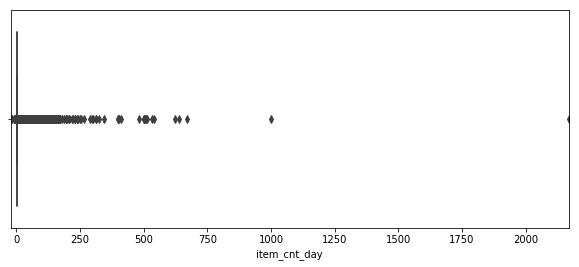

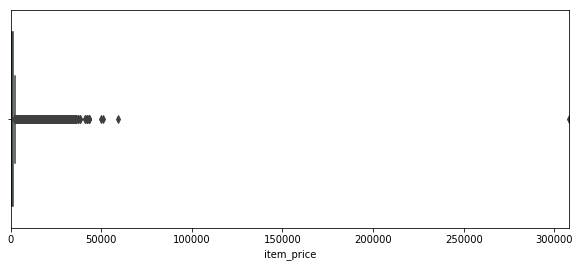

In [8]:
# 查看数据
plt.figure(figsize=(10, 4))
plt.xlim(sales_train.item_cnt_day.min(), sales_train.item_cnt_day.max())
sns.boxplot(x=sales_train.item_cnt_day)

plt.figure(figsize=(10, 4))
plt.xlim(sales_train.item_price.min(), sales_train.item_price.max())
sns.boxplot(x=sales_train.item_price)
# item_cnt_day有负值，（代表进货？意义未明）

In [9]:
# 移除异常值
# price > 100000 和  item_cnt_day > 1000
sales_train[sales_train.item_price > 100000]
sales_train[sales_train.item_cnt_day > 1000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2909818,28.10.2015,33,12,11373,0.908714,2169.0


In [10]:
sales_train = sales_train[sales_train.item_price < 100000][sales_train.item_cnt_day < 1001]
sales_train

D:\Anaconda3\envs\tensorflow_1\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
5,10.01.2013,0,25,2564,349.00,1.0
6,02.01.2013,0,25,2565,549.00,1.0
7,04.01.2013,0,25,2572,239.00,1.0
8,11.01.2013,0,25,2572,299.00,1.0
9,03.01.2013,0,25,2573,299.00,3.0


In [14]:
sales_train[sales_train.item_price < 0]
# 使用中位数修正这个数据
median = sales_train[(sales_train.shop_id == 32) & (sales_train.item_id == 2973) &
            (sales_train.date_block_num == 4) & (sales_train.item_price > 0)].item_price.median()
sales_train.loc[sales_train.item_price < 0, "item_price"] = median
sales_train.loc[(sales_train.shop_id == 32) & (sales_train.item_id == 2973) &
               (sales_train.date_block_num == 4)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484682,23.05.2013,4,32,2973,1249.0,1.0
484683,15.05.2013,4,32,2973,1874.0,1.0
484684,06.05.2013,4,32,2973,2499.0,1.0


In [15]:
# 根据名字修改 shops 中名字为 Жуковский ул. Чкалова 39м? ，Жуковский ул. Чкалова 39м² 的两项为一项
sales_train.loc[sales_train.shop_id == 10, "shop_id"] = 11 
test.loc[test.shop_id == 10, "shop_id"] = 11


In [16]:
# 预处理
# 将所有信息转变为数字
# Each shop_name starts with the city name.
# Each category contains type and subtype in its name.

# shops 一列转化为 shop_id 和 cityc_code 两列
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', "shop_name"] = 'СергиевПосад ТЦ "7Я"'
shops["city"] = shops.shop_name.str.split(" ").map(lambda x: x[0])
shops.loc[shops.city == "!Якутск", "city"] = "Якутск"
shops["city_code"] = LabelEncoder().fit_transform(shops.city)
shops_ = shops[["shop_id", "city_code", ]]
shops_

,shop_id,city_code
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2
5,5,3
6,6,4
7,7,4
8,8,4
9,9,5


In [17]:
# item_categories 转化为 item_category_id， type_code,  subtype_code 3列
item_categories["split"] = item_categories.item_category_name.str.split("-")
item_categories["type"] = item_categories.split.apply(lambda x: x[0].strip())
item_categories["type_code"] = LabelEncoder().fit_transform(item_categories.type)

# 如果没有 subtype 则定义为 type
item_categories["subtype"] = item_categories.split.apply(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
item_categories["subtype_code"] = LabelEncoder().fit_transform(item_categories["subtype"])

# 没有 subtype 的项目
item_categories[item_categories["type"] == item_categories["subtype"]]

item_categories_ = item_categories[["item_category_id", "type_code", "subtype_code"]]
item_categories_


,item_category_id,type_code,subtype_code
0,0,0,29
1,1,1,9
2,2,1,10
3,3,1,11
4,4,1,13
5,5,1,14
6,6,1,16
7,7,1,17
8,8,2,26
9,9,3,33


In [18]:
items_ = items.drop("item_name", axis=1)
items_

,item_id,item_category_id
0,0,40
1,1,76
2,2,40
3,3,40
4,4,40
5,5,40
6,6,40
7,7,40
8,8,40
9,9,40


In [19]:
# 测试集是训练集34的月的延伸，测试集中有大量的shop_id和item_id的组合，而测试集基本是有销售记录的组合的反馈信息
# 所以测试集中有很多的组合的销售值为0，所以可以计算每个组合在前34个月的销售额（没有的话取0）再进行延伸
len(list(set(test.item_id) - set(test.item_id).intersection(set(sales_train.item_id))))
# len(list(set(test.item_id)))
# len(test)

# 可见测试集和训练集中重复的条目仅有363条，商品条目5100条，组合214200种


363

In [20]:
ts = time.time()
matrix = []
cols = ["date_block_num", "shop_id", "item_id"]

for i in range(34):
    sales = sales_train[sales_train["date_block_num"] == i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype=np.int16))
    
# 生成dataframe
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix["date_block_num"] = matrix["date_block_num"].astype(np.int16)
matrix["shop_id"] = matrix["shop_id"].astype(np.int16) 
matrix["item_id"] = matrix["item_id"].astype(np.int16)
matrix.sort_values(by=cols, inplace=True)

time.time() - ts

11.543126106262207

In [21]:
# 通过shop/item的组合来集成测试集，再通过这个集合进行预测，
# 然后通过clip剪裁这个集合的销售值使之与测试集的预测结果更接近（因为销售数目大都是个位数）

#
sales_train["revenue"] = sales_train["item_price"] * sales_train["item_cnt_day"]
sales_train[sales_train["revenue"] < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue
2,05.01.2013,0,25,2552,899.00,-1.0,-899.00
148,23.01.2013,0,25,2321,999.00,-1.0,-999.00
175,07.01.2013,0,25,2199,1449.00,-1.0,-1449.00
807,02.01.2013,0,25,2330,599.00,-1.0,-599.00
1041,13.01.2013,0,25,5034,1989.00,-1.0,-1989.00
1193,02.01.2013,0,25,5651,5490.00,-1.0,-5490.00
1674,07.01.2013,0,25,4093,899.00,-1.0,-899.00
1825,02.01.2013,0,25,4249,1894.87,-1.0,-1894.87
2411,14.01.2013,0,24,1628,3899.00,-1.0,-3899.00
3216,08.01.2013,0,24,20948,899.00,-1.0,-899.00


In [22]:
ts = time.time()

# 计算每个组合每个月的销售总数
group = sales_train.groupby(by=["date_block_num", "shop_id", "item_id"])
group = group.agg({"item_cnt_day": ["sum"]})
group.columns = ["item_cnt_month"]
group.reset_index(inplace=True)

# 整合
matrix = pd.merge(matrix, group, on=cols, how="left")
matrix["item_cnt_month"] = matrix["item_cnt_month"].fillna(0).clip(0, 20).astype(np.float32)

time.time() - ts

5.599992036819458

In [23]:
# 对测试集的处理
ts = time.time()
test["date_block_num"] = 34
test["date_block_num"] = test["date_block_num"].astype(np.int16)
test["shop_id"] = test["shop_id"].astype(np.int16)
test["item_id"] = test["item_id"].astype(np.int16)
time.time() - ts

0.005987405776977539

In [24]:
ts = time.time()
matrix = pd.concat([matrix, test], ignore_index=True, keys=cols)
matrix.fillna(0, inplace=True)  

time.time() - ts

D:\Anaconda3\envs\tensorflow_1\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


0.2862057685852051

In [25]:
# 整合shops，items，item_categories到一个dataframe
ts = time.time()
matrix = pd.merge(matrix, shops_, how="left", on=["shop_id"])
matrix = pd.merge(matrix, items_, how="left", on=["item_id"])
matrix = pd.merge(matrix, item_categories_, how="left", on=["item_category_id"])

time.time() - ts

6.34403133392334

In [26]:
# 修改数据类型
ts = time.time()
matrix["city_code"] = matrix["city_code"].astype(np.int16)
matrix["item_category_id"] = matrix["item_category_id"].astype(np.int16)
matrix["type_code"] = matrix["type_code"].astype(np.int16)
matrix["subtype_code"] = matrix["subtype_code"].astype(np.int16)

time.time() - ts

0.24933171272277832

In [27]:
# 目标值延展得到预测值
def lag_feature(df, lags, col):
    tmp = df[["date_block_num", "shop_id", "item_id", col]]
    for i in lags:
        # 增加一共lags个新的dataframe，每个dataframe增加一列lag项，再进行整合
        shifted = tmp.copy()
        shifted.columns = ["date_block_num", "shop_id", "item_id", col+"_lag_"+str(i)]
        # 这一行修改了月份信息，对应于延后了i个月，也就是把所有数据整体向未来i个月漂移，再查看漂移后的数据与实际的差异        
        shifted["date_block_num"] += i
        df = pd.merge(df, shifted, on=["date_block_num", "shop_id", "item_id"], how="left")
    return df

In [28]:
# 每个月每个{shop，item}组合的销售数目
ts = time.time()
matrix = lag_feature(matrix, [1, 2, 3, 4, 5, 6], "item_cnt_month")

time.time() - ts

44.48100018501282

In [29]:
# 特征工程
# 平均值作为编码后的项目的特征
# 商品的销售量和月份的关系
ts = time.time()
group = matrix.groupby(by=["date_block_num"]).agg({"item_cnt_month": ["mean"]})
group.columns = ["average_item_cnt_month"]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, how="left", on=["date_block_num"])
matrix["average_item_cnt_month"] = matrix["average_item_cnt_month"].astype(np.float32)

# # 延伸一个月
matrix = lag_feature(matrix, [1], "average_item_cnt_month")
matrix.drop("average_item_cnt_month", axis=1, inplace=True)

time.time() - ts

12.91444730758667

In [31]:
# 商品销售量和（每个月的）商品条目的关系
ts = time.time()
group = matrix.groupby(["date_block_num", "item_id"]).agg({"item_cnt_month": ["mean"]})
group.columns = ["average_date_item_cnt_month"]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, how="left", on=["date_block_num", "item_id"])
matrix["average_date_item_cnt_month"] = matrix["average_date_item_cnt_month"].astype(np.float32)
matrix = lag_feature(matrix, [1, 2, 3, 4, 5, 6], "average_date_item_cnt_month")
matrix.drop("average_date_item_cnt_month", axis=1, inplace=True)

time.time() - ts

59.53875541687012

In [32]:
# 商品销售量和（每个月的）商店的关系
ts = time.time()
group = matrix.groupby(["date_block_num", "shop_id"]).agg({"item_cnt_month": ["mean"]})
group.columns = ["average_date_shop_item_cnt_month"]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, how="left", on=["date_block_num", "shop_id"])
matrix["average_date_shop_item_cnt_month"] = matrix["average_date_shop_item_cnt_month"].astype(np.float32)
matrix = lag_feature(matrix, [1, 2, 3, 4, 5, 6], "average_date_shop_item_cnt_month")
matrix.drop("average_date_shop_item_cnt_month", axis=1, inplace=True)

time.time() - ts

63.65973424911499

In [33]:
# 商品销售量和（每个月的）商品种类的关系
ts = time.time()
group = matrix.groupby(["date_block_num", "item_category_id"]).agg({"item_cnt_month": ["mean"]})
group.columns = ["average_date_category_item_cnt_month"]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, how="left", on=["date_block_num", "item_category_id"])
matrix["average_date_category_item_cnt_month"] = matrix["average_date_category_item_cnt_month"].astype(np.float32)
matrix = lag_feature(matrix, [1], "average_date_category_item_cnt_month")
matrix.drop("average_date_category_item_cnt_month", axis=1, inplace=True)

time.time() - ts

17.272799730300903

In [34]:
# 商品销售量和（每个月的在不同商店的）商品种类的关系
ts = time.time()
group = matrix.groupby(["date_block_num", "shop_id", "item_category_id"]).agg({"item_cnt_month": ["mean"]})
group.columns = ["average_date_shop_category_item_cnt_month"]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, how="left", on=["date_block_num", "shop_id", "item_category_id"])
matrix["average_date_shop_category_item_cnt_month"] = matrix["average_date_shop_category_item_cnt_month"].astype(np.float32)
matrix = lag_feature(matrix, [1], "average_date_shop_category_item_cnt_month")
matrix.drop("average_date_shop_category_item_cnt_month", axis=1, inplace=True)

time.time() - ts

18.12153124809265

In [35]:
# 商品销售量和（每个月的在不同商店的）商品种类的主类型的关系
ts = time.time()
group = matrix.groupby(["date_block_num", "shop_id", "type_code"]).agg({"item_cnt_month": ["mean"]})
group.columns = ["average_date_shop_type_item_cnt_month"]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, how="left", on=["date_block_num", "shop_id", "type_code"])
matrix["average_date_shop_type_item_cnt_month"] = matrix["average_date_shop_type_item_cnt_month"].astype(np.float32)
matrix = lag_feature(matrix, [1], "average_date_shop_type_item_cnt_month")
matrix.drop("average_date_shop_type_item_cnt_month", axis=1, inplace=True)

time.time() - ts

18.865540981292725

In [36]:
# 商品销售量和（每个月的在不同商店的）商品种类的副类型的关系
ts = time.time()
group = matrix.groupby(["date_block_num", "shop_id", "subtype_code"]).agg({"item_cnt_month": ["mean"]})
group.columns = ["average_date_shop_subtype_item_cnt_month"]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, how="left", on=["date_block_num", "shop_id", "subtype_code"])
matrix["average_date_shop_subtype_item_cnt_month"] = matrix["average_date_shop_subtype_item_cnt_month"].astype(np.float32)
matrix = lag_feature(matrix, [1], "average_date_shop_subtype_item_cnt_month")
matrix.drop("average_date_shop_subtype_item_cnt_month", axis=1, inplace=True)

time.time() - ts

20.494184970855713

In [37]:
# 商品销售量和（每个月的）城市的关系
ts = time.time()
group = matrix.groupby(["date_block_num", "city_code"]).agg({"item_cnt_month": ["mean"]})
group.columns = ["average_date_city_item_cnt_month"]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, how="left", on=["date_block_num", "city_code"])
matrix["average_date_city_item_cnt_month"] = matrix["average_date_city_item_cnt_month"].astype(np.float32)
matrix = lag_feature(matrix, [1], "average_date_city_item_cnt_month")
matrix.drop("average_date_city_item_cnt_month", axis=1, inplace=True)

time.time() - ts

21.21126699447632

In [38]:
# 商品销售量和（每个月的商品条目下的）城市的关系
ts = time.time()
group = matrix.groupby(["date_block_num", "item_id", "city_code"]).agg({"item_cnt_month": ["mean"]})
group.columns = ["average_date_item_city_item_cnt_month"]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, how="left", on=["date_block_num", "item_id", "city_code"])
matrix["average_date_item_city_item_cnt_month"] = matrix["average_date_item_city_item_cnt_month"].astype(np.float32)
matrix = lag_feature(matrix, [1], "average_date_item_city_item_cnt_month")
matrix.drop("average_date_item_city_item_cnt_month", axis=1, inplace=True)

time.time() - ts

26.88708782196045

In [39]:
# 商品销售量和（每个月的）商品主类型的关系
ts = time.time()
group = matrix.groupby(["date_block_num", "type_code"]).agg({"item_cnt_month": ["mean"]})
group.columns = ["average_date_type_item_cnt_month"]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, how="left", on=["date_block_num", "type_code"])
matrix["average_date_type_item_cnt_month"] = matrix["average_date_type_item_cnt_month"].astype(np.float32)
matrix = lag_feature(matrix, [1], "average_date_type_item_cnt_month")
matrix.drop("average_date_type_item_cnt_month", axis=1, inplace=True)

time.time() - ts

19.677371740341187

In [40]:
# 商品销售量和（每个月的）商品副类型的关系
ts = time.time()
group = matrix.groupby(["date_block_num", "subtype_code"]).agg({"item_cnt_month": ["mean"]})
group.columns = ["average_date_subtype_item_cnt_month"]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, how="left", on=["date_block_num", "subtype_code"])
matrix["average_date_subtype_item_cnt_month"] = matrix["average_date_subtype_item_cnt_month"].astype(np.float32)
matrix = lag_feature(matrix, [1], "average_date_subtype_item_cnt_month")
matrix.drop("average_date_subtype_item_cnt_month", axis=1, inplace=True)

time.time() - ts

19.9237117767334

In [41]:
# 过去六个月价格变化趋势
# 商品价格和商品条目的关系（所有月份）
ts = time.time()
group = sales_train.groupby(by=["item_id"]).agg({"item_price": ["mean"]})
group.columns = ["average_price_item"]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, how="left", on=["item_id"])
matrix["average_price_item"] = matrix["average_price_item"].astype(np.float32)

# 商品价格与（每个月的）商品条目的关系
group = sales_train.groupby(by=["date_block_num", "item_id"]).agg({"item_price": ["mean"]})
group.columns = ["average_date_price_item"]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, how="left", on=["date_block_num", "item_id"])
matrix["average_date_price_item"] = matrix["average_date_price_item"].astype(np.float32)
lags = [1, 2, 3, 4, 5, 6]
matrix = lag_feature(matrix, lags, "average_date_price_item")

time.time() - ts

71.18759441375732

In [42]:
# 计算每个月的变化量
# lags = [1, 2, 3, 4, 5, 6]
ts = time.time()
for i in lags:
    matrix["delta_price_lag_" + str(i)] = (matrix["average_date_price_item_lag_" + str(i)] - matrix["average_date_price_item"]) / matrix["average_date_price_item"]

time.time() - ts

0.5824408531188965

In [43]:
# 整合delta_price_lag的数据到一列
ts = time.time()
def whole_trend(df):
    for i in lags:
        if df["delta_price_lag_" + str(i)]:
            return df["delta_price_lag_" + str(i)]
    return 0

matrix["delta_price_lag"] = matrix.apply(whole_trend, axis=1)
matrix["delta_price_lag"] = matrix["delta_price_lag"].astype(np.float32)
matrix["delta_price_lag"].fillna(0, inplace=True)

time.time() - ts

341.5714211463928

In [44]:
# 删掉多余的列只保留特征列
ts = time.time()
features = ["average_price_item", "average_date_price_item"]
for i in lags:
    features += ["average_date_price_item_lag_" + str(i)]
    features += ["delta_price_lag_" + str(i)]
    
matrix.drop(features, axis=1, inplace=True)

time.time() - ts

13.522831201553345

In [46]:
# 查看每个商店的收益趋势
# 每个商店（每月的）收益
ts = time.time()
group = sales_train.groupby(["date_block_num", "shop_id"]).agg({"revenue": ["sum"]})
group.columns = ["sum_date_shop_revenue"]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=["date_block_num", "shop_id"], how="left")
matrix["sum_date_shop_revenue"] = matrix["sum_date_shop_revenue"].astype(np.float32)

# 每个商店的收益
group = group.groupby(["shop_id"]).agg({"sum_date_shop_revenue": ["mean"]})
group.columns = ["average_shop_revenue"]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=["shop_id"], how="left")
matrix["average_shop_revenue"] = matrix["average_shop_revenue"].astype(np.float32)

# 每个月的变化量
matrix["delta_revenue"] = (matrix["sum_date_shop_revenue"] - matrix["average_shop_revenue"]) / matrix["average_shop_revenue"]
matrix["delta_revenue"] = matrix["delta_revenue"].astype(np.float32)
matrix = lag_feature(matrix, [1, 2, 3], "delta_revenue")
matrix.drop(["sum_date_shop_revenue", "average_shop_revenue", "delta_revenue"], axis=1, inplace=True)

time.time() - ts

41.42719841003418

In [47]:
# 其他特征量
# 将date_block_num设置每个月份，再转化为天数
ts = time.time()
matrix["month"] = matrix["date_block_num"] % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix["days"] = matrix["month"].map(days).astype(np.int16)

time.time() - ts

0.4039194583892822

In [48]:
# 创建哈希表，键值对分别是{shop_id, item_id}和date_block_num
# 迭代每一行查看{row.shop_id, row.item_id}是否存在于表中，没有的话就加入表中并将对应值设置为row.date_block_num
# 有的话就计算表中的值与当前行的值的差值


In [49]:
ts = time.time()
matrix["item_shop_last_sale"] = -1  # 0代表了第一个月
matrix["item_shop_last_sale"] = matrix["item_shop_last_sale"].astype(np.int16)
cache = {}
for index, row in matrix.iterrows():
    key = str(row.item_id) + " " + str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month != 0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[index, "item_shop_last_sale"] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num
        
time.time() - ts

1109.3281474113464

In [50]:
ts = time.time()
matrix["item_last_sale"] = -1
matrix["item_last_sale"] = matrix["item_last_sale"].astype(np.int16)
cache = {}
for index, row in matrix.iterrows():
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month != 0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num > last_date_block_num:
            matrix.at[index, "item_last_sale"] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num
            
time.time() - ts

582.465126991272

In [52]:
# 计算每个{shop_id, item_id}对和每个item的从初次售出月份到当前月份经历的时间
ts = time.time()
matrix["item_shop_first_sale"] = matrix["date_block_num"] - matrix.groupby(["item_id", "shop_id"])["date_block_num"].transform("min")
matrix["item_first_sale"] = matrix["date_block_num"] - matrix.groupby("item_id")["date_block_num"].transform("min")
                                                                                                                               
time.time() - ts                                        

3.8257672786712646

In [53]:
# 丢弃无法用于计算测试集的列
# lag_feature函数使用了12这个值来延后整体数据，因此前12个月的数据可以丢弃掉
ts = time.time()
matrix = matrix[matrix["date_block_num"] > 11]

time.time() - ts

1.3623549938201904

In [54]:
# 设置使用了lag_feature函数而产生的空值为0
ts = time.time()
for col in matrix.columns:
    if ("_lag_" in col) & (matrix[col].isnull().any()):
        if "item_cnt" in col:
            matrix[col].fillna(0, inplace=True)

time.time() - ts

4.413193941116333

In [55]:
matrix.columns

Index(['date_block_num', 'item_cnt_month', 'item_id', 'shop_id', 'city_code',
       'item_category_id', 'type_code', 'subtype_code', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_4',
       'item_cnt_month_lag_5', 'item_cnt_month_lag_6',
       'average_item_cnt_month_lag_1', 'average_date_item_cnt_month_lag_1',
       'average_date_item_cnt_month_lag_2',
       'average_date_item_cnt_month_lag_3',
       'average_date_item_cnt_month_lag_4',
       'average_date_item_cnt_month_lag_5',
       'average_date_item_cnt_month_lag_6',
       'average_date_shop_item_cnt_month_lag_1',
       'average_date_shop_item_cnt_month_lag_2',
       'average_date_shop_item_cnt_month_lag_3',
       'average_date_shop_item_cnt_month_lag_4',
       'average_date_shop_item_cnt_month_lag_5',
       'average_date_shop_item_cnt_month_lag_6',
       'average_date_category_item_cnt_month_lag_1',
       'average_date_shop_category_item_cnt_month_lag_1',
       

In [56]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6639294 entries, 4488710 to 11128003
Data columns (total 46 columns):
date_block_num                                     int16
item_cnt_month                                     float32
item_id                                            int16
shop_id                                            int16
city_code                                          int16
item_category_id                                   int16
type_code                                          int16
subtype_code                                       int16
item_cnt_month_lag_1                               float32
item_cnt_month_lag_2                               float32
item_cnt_month_lag_3                               float32
item_cnt_month_lag_4                               float32
item_cnt_month_lag_5                               float32
item_cnt_month_lag_6                               float32
average_item_cnt_month_lag_1                       float32
average_d

In [57]:
# 将处理的数据保存成pickle形式
matrix.to_pickle("processed_data1.pkl")
del matrix
del cache
del group
del items, items_
del shops, shops_
del item_categories, item_categories_
del sales_train

gc.collect()

56